# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from copy import deepcopy

# Functions

In [2]:
def det_feat(img):
    #function for detecting SIFT features
    
    sift = cv2.xfeatures2d.SIFT_create()
    points, descriptors = sift.detectAndCompute(img, None)
    
    return points, descriptors

def match(img1, img2):
    #function for matching two images
    
    #get features for each image
    p1, d1 = det_feat(img1)
    p2, d2 = det_feat(img2)
    
    #find nearest neighbours for each image
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(d1, d2, k=2)
    
    #find good neighbours to be considered as matches
    top = []
    matching_inds = []
    for a, b in matches:
        if a.distance < 0.75*b.distance:
            top.append([a])
            matching_inds.append((a.queryIdx, a.trainIdx))
    
    return p1, d1, p2, d2, np.array(matching_inds), top

def get_matching_coords(p1, p2, matching_inds):
    pts1, pts2 = [], []
    for i in range(matching_inds.shape[0]):
        pts1.append(p1[matching_inds[i, 0]].pt)
        pts2.append(p2[matching_inds[i, 1]].pt)
    pts1 = np.array(pts1)
    pts2 = np.array(pts2)
    
    return pts1, pts2

def calc_err(a, b):
    a = a - a.mean(axis=(0, 1))
    b = b - b.mean(axis=(0, 1))
    a, b = a.flatten(), b.flatten()
    return np.matmul(a.T, b) / ((np.linalg.norm(a) * np.linalg.norm(b)) + 1e-8)

def window_match(img1, img2, sz, stride, inline):
    #intensity based window matcher
    matches = []

    for i in range(sz//2, img1.shape[0] - sz//2, stride):
        for j in range(sz//2, img1.shape[1] - sz//2, stride):
            start1 = max(sz//2, i - 3*sz)
            start2 = max(sz//2, j - 3*sz)
            end1 = min(i + 3*sz, img2.shape[0] - sz//2)
            end2 = min(j + 3*sz, img2.shape[1] - sz//2)
            maxx = -1e18
            if inline:
                for l in range(start2, end2, stride):
                    sim = calc_err(img1[i-sz//2:i+sz//2, j-sz//2:j+sz//2, :],
                                   img2[i-sz//2:i+sz//2, l-sz//2:l+sz//2, :])
                    if sim > maxx:
                        maxx = sim
                        inds = [i, l]
            else:
                for k in range(start1, end1, stride):
                    for l in range(start2, end2, stride):
                        sim = calc_err(img1[i-sz//2:i+sz//2, j-sz//2:j+sz//2, :],
                                       img2[k-sz//2:k+sz//2, l-sz//2:l+sz//2, :])
                        if sim > maxx:
                            maxx = sim
                            inds = [k, l]
            matches.append([i, j, inds[0], inds[1], sim])
    return matches

def naive_match(img, img1, img2, sz, stride, inline=False):
    #matching points are found out
    m = window_match(img1, img2, sz, stride, inline)
    #rough threshold is calculated
    avg = 0;
    for i in range(len(m)):
        avg += m[i][4]
    avg /= len(m)
    #thresholded matches are displayed
    already = set([])
    for i in range(len(m)):
        if m[i][4] > avg + 0.1:
            #uncomment to remove overlapping matches from display
            ##########################
            f = 0
            for val in already:
                if m[i][0] >= val - 10 and m[i][0] <= val + 10:
                    f += 1
                    break
            if f == 1:
                continue
            ##########################

            col = np.uint8(np.random.uniform(0, 255, 3))
            col = tuple(map(int, col))
            img = cv2.line(img, tuple([m[i][1], m[i][0]]), 
                               tuple([img1.shape[1] + m[i][3], m[i][2]]), 
                               col, 1)
            already.add(m[i][0])

    plt.figure(figsize=(10, 10))
    plt.title("Intensity Window based matching.")
    plt.imshow(img)
    plt.show()
    
    return m

def stereo_rectification(img1, img2):
    
    #match the sift features
    p1, d1, p2, d2, matching_inds, top = match(img1, img2)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.drawMatchesKnn(img1, p1, img2, p2, top, None, flags=2))
    plt.title("SIFT Matching")
    plt.show()
    
    #get matching coordinates
    pts1, pts2 = get_matching_coords(p1, p2, matching_inds)
    
    #determine the Fundamental Matrix
    F, mask = cv2.findFundamentalMat(pts1, pts2, method=cv2.RANSAC)
    mask = np.squeeze(mask)
    pts1, pts2 = pts1[mask==1], pts2[mask==1]
    
    #determine homographies for stereo rectification
    _, H1, H2 = cv2.stereoRectifyUncalibrated(pts1, pts2, F, (img1.shape[1], img.shape[0]))
    
    #rectiify the images
    img1_rect = cv2.warpPerspective(img1, H1, (img1.shape[1], img.shape[0]))
    img2_rect = cv2.warpPerspective(img2, H2, (img1.shape[1], img.shape[0]))
    
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 10)
    axs[0].imshow(img1_rect)
    axs[0].title.set_text("Image 1 rectified")
    axs[1].imshow(img2_rect)
    axs[1].title.set_text("Image 2 rectified")
    plt.show()
    
    return img1_rect, img2_rect

# Execution

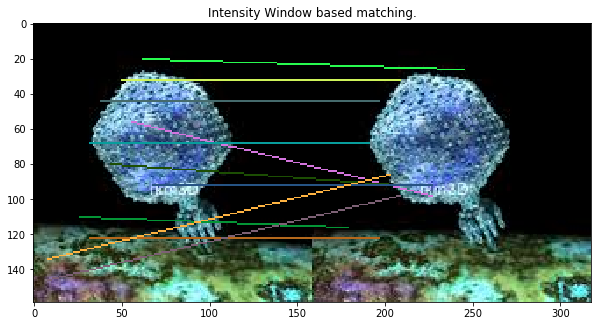

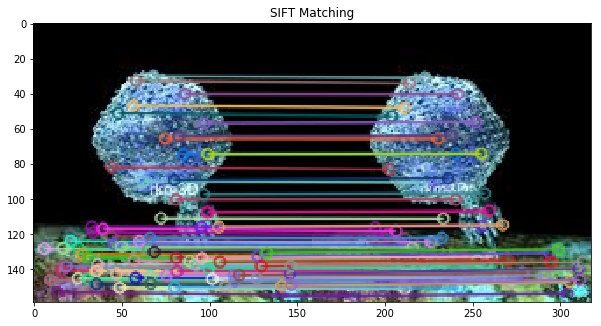

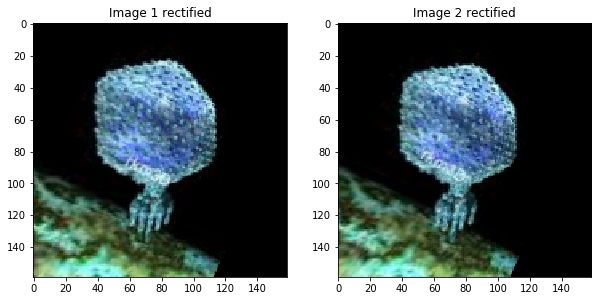

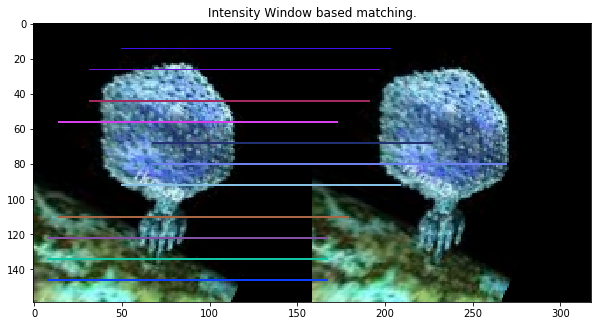

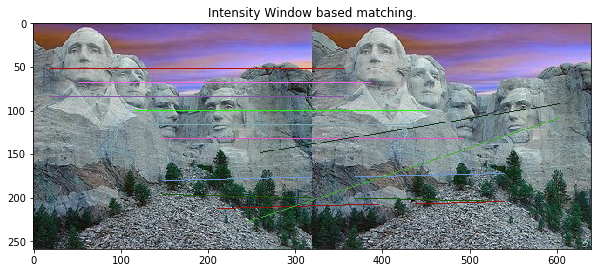

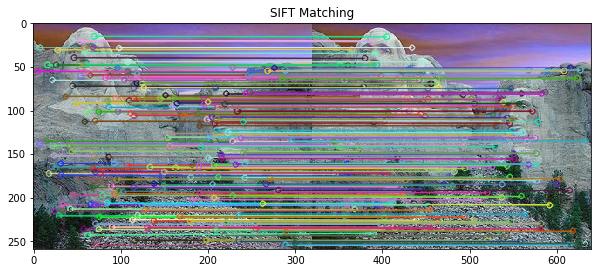

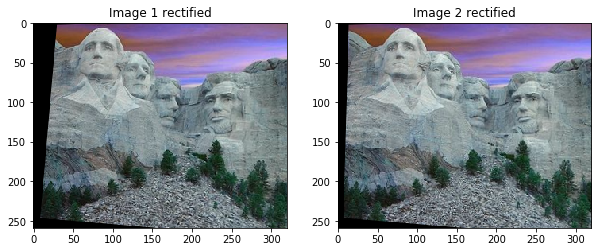

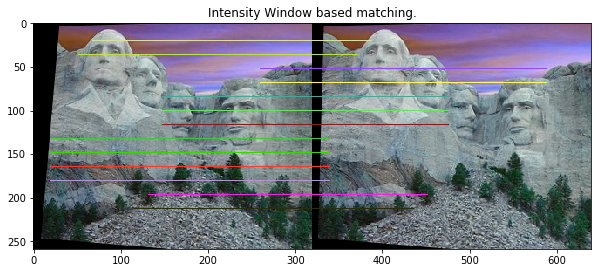

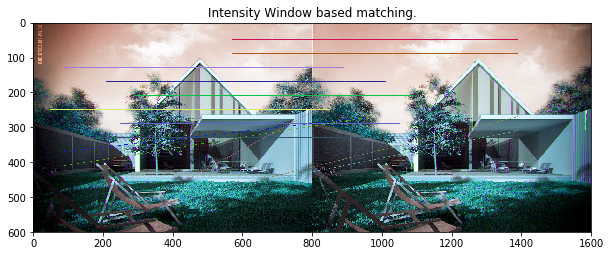

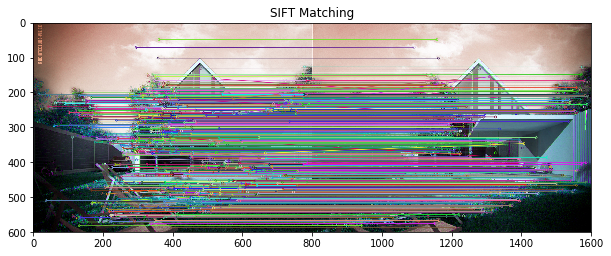

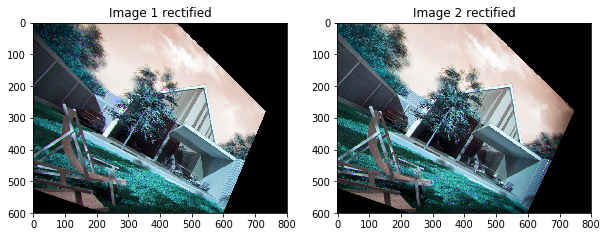

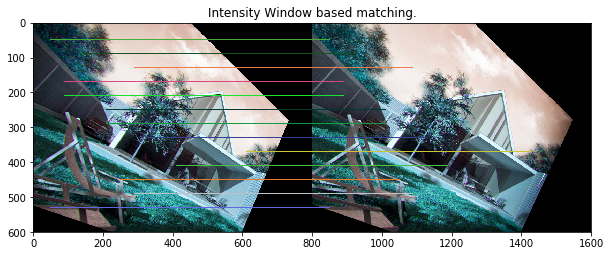

In [3]:
#done for all three images
paths = ['../images/stereo_images/3.jpeg', '../images/stereo_images/2.jpg', '../images/stereo_images/1.jpg']
sizes = [16, 40, 100]
strides = [6, 16, 40]
for q in range(len(paths)):
    img = cv2.imread(paths[q])
    img1 = deepcopy(img[:, :img.shape[1]//2])
    img2 = deepcopy(img[:, img.shape[1]//2:])
    
    ## PART 1 ##
    matches = np.array(naive_match(img, img1, img2, sizes[q], strides[q]))
    ############
    
    ## PART 2 ##
    img1, img2 = stereo_rectification(img1, img2)
    
    #recreate the combined image
    img[:, :img1.shape[1], :] = img1
    img[:, img1.shape[1]:, :] = img2
    
    #match along the same horizontal lines
    naive_match(img, img1, img2, sizes[q], strides[q], True)
    ############